# Titanic Analysis

## History

#### Import packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder 
import csv

In [3]:
train = pd.read_csv('train.csv', sep=',')
test = pd.read_csv('test.csv', sep=',')

#### Data cleaning

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train.duplicated().value_counts()

False    891
Name: count, dtype: int64

In [5]:
cat_col = []
num_col = []

for col in train.columns:
    if train[col].dtype == 'object':
        cat_col.append(col)
    else:
        num_col.append(col)

print('Categorical columns: ', cat_col)
print('Numerical columns: ', num_col)

Categorical columns:  ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
Numerical columns:  ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [6]:
train[cat_col].nunique()

Name        891
Sex           2
Ticket      681
Cabin       147
Embarked      3
dtype: int64

In [7]:
train['Ticket'].unique()[:100]

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '19950', '330959', '349216', 'PC 17601',
       'PC 17569', '335677', 'C.A. 24579', 'PC 17604', '113789', '2677',
       'A./5. 2152', '345764', '2651', '7546', '11668', '349253',
       'SC/Paris 2123', '330958', 'S.C./A.4. 23567', '370371', '14311',
       '2662', '349237', '3101295', 'A/4. 39886', 'PC 17572', '2926',
       '113509', '19947', 'C.A. 31026', '2697', 'C.A. 34651', 'CA 2144',
       '2669', '113572', '36973', '347088', 'PC 17605', '2661',
       'C.A. 29395', 'S.P. 3464', '3101281', '315151', 'C.A. 33111',
       'S.O.C. 14879', '2680', '1601', '348123', '349208', '374746',
       '248738', '364516', '345767', '345779', '330932', '113059',
       'SO/C 14885', '31012

In [24]:
train = train.drop(columns=['Name', 'Ticket'])
train.shape

nan


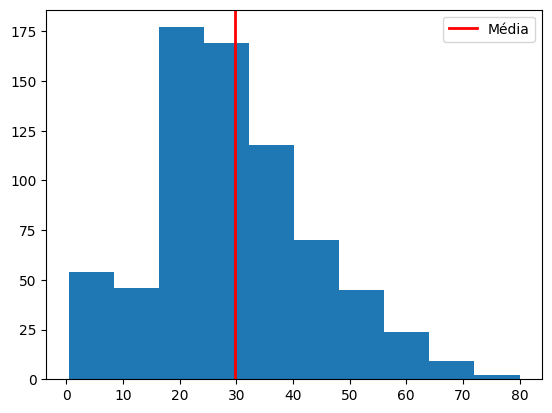

In [25]:
plt.hist(x='Age',  data=train)
plt.axvline(np.mean(train['Age']), color='red', linestyle='solid', linewidth=2, label='Média')
plt.legend()
#plt.axvline(np.median(train['Age']), color='blue', linestyle='dashed', linewidth=2, label='Média')
plt.show()

#### tratamento de dados faltantes

In [9]:
print('Percentual (%) de valores ausentes em cada coluna')

print(pd.DataFrame({'Counts': train.count(), 'Counts unique': train.nunique(),'Counts NA': train.isnull().sum(),'Percentages (%) NA':  round(train.isnull().sum()/train.shape[0]*100,2)}))

Percentual (%) de valores ausentes em cada coluna
             Counts  Counts unique  Counts NA  Percentages (%) NA
PassengerId     891            891          0                0.00
Survived        891              2          0                0.00
Pclass          891              3          0                0.00
Sex             891              2          0                0.00
Age             714             88        177               19.87
SibSp           891              7          0                0.00
Parch           891              7          0                0.00
Fare            891            248          0                0.00
Cabin           204            147        687               77.10
Embarked        889              3          2                0.22


In [10]:
train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,71.2833,C85,C
2,3,1,3,female,26.0,0,0,7.9250,NaN,S
3,4,1,1,female,35.0,1,0,53.1000,C123,S
4,5,0,3,male,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,NaN,S
887,888,1,1,female,19.0,0,0,30.0000,B42,S
888,889,0,3,female,NaN,1,2,23.4500,NaN,S
889,890,1,1,male,26.0,0,0,30.0000,C148,C


In [11]:
## valores NA

train = train.fillna(train['Age'].mean())

In [12]:

train['faixa_age'] =  pd.cut(train['Age'], bins=[0, 18, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], right=False)

##### One hot encoded

In [13]:
train['Sex'] = train['Sex'].astype('category')
train['faixa_age'] = train['faixa_age'].astype('category')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Sex          891 non-null    category
 4   Age          891 non-null    float64 
 5   SibSp        891 non-null    int64   
 6   Parch        891 non-null    int64   
 7   Fare         891 non-null    float64 
 8   Cabin        891 non-null    object  
 9   Embarked     891 non-null    object  
 10  faixa_age    891 non-null    category
dtypes: category(2), float64(2), int64(5), object(2)
memory usage: 65.0+ KB


In [14]:
# Assigning numerical values and storing it in another columns 
train['Sex_new'] = train['Sex'].cat.codes 
train['faixa_age_new'] = train['faixa_age'].cat.codes 
  
# Create an instance of One-hot-encoder 
enc = OneHotEncoder() 
  
# Passing encoded columns 
enc_data = pd.DataFrame(enc.fit_transform(train[['Sex_new', 'faixa_age_new']]).toarray()) 

# Merge with main 
train = train.join(enc_data)

In [15]:
train.iloc[:, :13]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,faixa_age,Sex_new,faixa_age_new
0,1,0,3,male,22.000000,1,0,7.2500,29.699118,S,3,1,2
1,2,1,1,female,38.000000,1,0,71.2833,C85,C,4,0,3
2,3,1,3,female,26.000000,0,0,7.9250,29.699118,S,3,0,2
3,4,1,1,female,35.000000,1,0,53.1000,C123,S,4,0,3
4,5,0,3,male,35.000000,0,0,8.0500,29.699118,S,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.000000,0,0,13.0000,29.699118,S,3,1,2
887,888,1,1,female,19.000000,0,0,30.0000,B42,S,2,0,1
888,889,0,3,female,29.699118,1,2,23.4500,29.699118,S,3,0,2
889,890,1,1,male,26.000000,0,0,30.0000,C148,C,3,1,2


In [16]:
train['faixa_age_new'].unique()

array([2, 3, 5, 0, 1, 4, 6, 7, 8], dtype=int8)

In [ ]:
test = test.fillna(test['Age'].mean())
one_hot_encoded_data_test = pd.get_dummies(test, columns = ['Sex'], dtype='int') 
one_hot_encoded_data_test['faixa_age'] =  pd.cut(test['Age'], bins=[0, 18, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], right=False)
one_hot_encoded_data_test

In [ ]:
one_hot_encoded_data_test = one_hot_encoded_data_test[['Sex_female', 'Sex_male', 'Pclass', 'Age', 'faixa_age', 'Fare']]
one_hot_encoded_data_test

In [17]:
one_hot_encoded_data_test.isnull().sum()

NameError: name 'one_hot_encoded_data_test' is not defined

In [ ]:
matrix_corr = one_hot_encoded_data.drop(columns=['Cabin', 'Embarked']).corr()

plt.figure(figsize=(14, 8))
sns.heatmap(matrix_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

In [20]:
X = train[['Sex_new', 'faixa_age_new', 'Pclass', 'Age', 'faixa_age', 'Fare']]
y = train.Survived

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.5, random_state=1)

In [22]:
mod = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=1)
mod.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=1)

In [23]:
X_prev = mod.predict(X_valid)
X_prev, X_prev.shape

(array([1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 

In [24]:
np.mean(y_valid == X_prev)

0.7825112107623319

In [25]:
# metodo de reamostragem
# validação cruzada 
resultados = []
for i in range(10):
    print('Rep:', i)
    kf = KFold(2, shuffle=True, random_state=i)
    for line_train, line_valid in kf.split(X):
        print('Treino: ', line_train.shape[0])
        print('Valid: ', line_valid.shape[0])

        X_train, X_valid = X.iloc[line_train], X.iloc[line_valid]
        y_train, y_valid = y.iloc[line_train], y.iloc[line_valid]


        mod = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=1)
        mod.fit(X_train, y_train)


        X_prev = mod.predict(X_valid)
        acc = np.mean(y_valid == X_prev)
        resultados.append(acc)
        print('Acc:', acc)
        print()

Rep: 0
Treino:  445
Valid:  446
Acc: 0.8071748878923767

Treino:  446
Valid:  445
Acc: 0.8224719101123595

Rep: 1
Treino:  445
Valid:  446
Acc: 0.7825112107623319

Treino:  446
Valid:  445
Acc: 0.8157303370786517

Rep: 2
Treino:  445
Valid:  446
Acc: 0.8183856502242153

Treino:  446
Valid:  445
Acc: 0.7775280898876404

Rep: 3
Treino:  445
Valid:  446
Acc: 0.7914798206278026

Treino:  446
Valid:  445
Acc: 0.7842696629213484

Rep: 4
Treino:  445
Valid:  446
Acc: 0.8139013452914798

Treino:  446
Valid:  445
Acc: 0.7573033707865169

Rep: 5
Treino:  445
Valid:  446
Acc: 0.8161434977578476

Treino:  446
Valid:  445
Acc: 0.7707865168539326

Rep: 6
Treino:  445
Valid:  446
Acc: 0.7937219730941704

Treino:  446
Valid:  445
Acc: 0.7955056179775281

Rep: 7
Treino:  445
Valid:  446
Acc: 0.7802690582959642

Treino:  446
Valid:  445
Acc: 0.8179775280898877

Rep: 8
Treino:  445
Valid:  446
Acc: 0.8026905829596412

Treino:  446
Valid:  445
Acc: 0.8292134831460675

Rep: 9
Treino:  445
Valid:  446
Acc: 

In [26]:
resultados

[0.8071748878923767,
 0.8224719101123595,
 0.7825112107623319,
 0.8157303370786517,
 0.8183856502242153,
 0.7775280898876404,
 0.7914798206278026,
 0.7842696629213484,
 0.8139013452914798,
 0.7573033707865169,
 0.8161434977578476,
 0.7707865168539326,
 0.7937219730941704,
 0.7955056179775281,
 0.7802690582959642,
 0.8179775280898877,
 0.8026905829596412,
 0.8292134831460675,
 0.7937219730941704,
 0.8292134831460675]

In [ ]:
np.mean(resultados)

In [27]:
with open('gender_submission1.csv', 'w', newline='') as prediction:
    fields = ['PassengerId', 'Survived']
    prediction_writer = csv.DictWriter(prediction, fieldnames=fields)
    prediction_writer.writeheader()
    for passenger_id, survived in pd.Series(X_prev, index=test['PassengerId']).items():
        prediction_writer.writerow({'PassengerId': passenger_id, 'Survived': survived})


ValueError: Length of values (445) does not match length of index (418)